In [1]:
using ForwardDiff, Plots, NLsolve, LsqFit, Optim

In [25]:
k_B = 1.38e-23  # Boltzmann constant in J/K
T = 298  # Temperature in Kelvin
sigma = 0.0098  # Surface tension in J/m² (dyne/cm converted to J/m²)
a = 270e-9  # Droplet radius in meters
xi = 0.15  # Dimensionless parameter
epsilon_r = 78.5  # Relative permittivity of water
epsilon_0 = 8.85e-12  # Permittivity of vacuum in F/m
psi_0 = 270e-3  # Surface potential in volts
lambda_D = 3.4e-9  # Debye length in meters
phi_c = 0.646  # Critical volume fraction
alpha = 0.85  # Shear effect parameter
V_drop = (4/3) * π * a^3  # Droplet volume in cubic meters

8.244795760081054e-20

In [26]:
function F_int(phi_d)
    return 4 * π * xi * sigma * (a^2) * (phi_d^2) 
end

# function F_ent(phi, phi_d, gamma)
#     return -3 * k_B * T * log(phi_c + phi_d - phi - alpha * gamma^2)
# end

# function F_elec(phi_d, phi, gamma)
#     h = 2 * phi_c^(1/3) * a * ((phi .+ 0im).^(-1/3) - (phi_c + phi_d .- alpha * gamma^2 .+ 0im).^(-1/3))
#     return 2 * π * a^2 * epsilon_r * epsilon_0 * psi_0^2 * exp.(-h / lambda_D) ./ h
# end

function F_ent(phi, phi_d, gamma)
    term = phi_c + phi_d - phi - alpha * gamma^2
    if term <= 0
        return Inf  # Return a large value to avoid invalid log
    end
    return -3 * k_B * T * log(term)
end


function F_elec(phi_d, phi, gamma)
    h_complex = 2 * phi_c^(1/3) * a * ((phi + 0im)^(-1/3) - (phi_c + phi_d - alpha * gamma^2 + 0im)^(-1/3))
    h = real(h_complex)  # Take the real part only
    if h <= 0
        return 0  # Return zero or another suitable value to avoid invalid division
    end
    return 2 * π * a^2 * epsilon_r * epsilon_0 * psi_0^2 * exp(-h / lambda_D) / h
end




function F_tot(phi_d, phi, gamma)
    term = phi_c .+ phi_d .- phi .- alpha .* gamma.^2
    if term <= 0
        return Inf  # Return a large value to avoid invalid log
    end
    return F_int(phi_d) + F_ent(phi, phi_d, gamma) + F_elec(phi, phi_d, gamma)
end


F_tot (generic function with 1 method)

In [27]:
function find_phid_star(phi, gamma)
    f_prime(phi_d_vec) = ForwardDiff.derivative(phi_d -> F_tot(phi_d, phi, gamma), phi_d_vec[1])
    
    result = nlsolve(f_prime, [1e-15]; inplace=false)  # Initial guess without bounds
    phi_d_star = result.zero[1]  

    boundary_condition = phi_c - phi - alpha * gamma^2

    if boundary_condition > 0
        lower_bound = 0
    else
        lower_bound = phi + alpha * gamma^2 - phi_c
    end

    if phi_d_star < lower_bound
        return lower_bound
    end
    return phi_d_star
end

find_phid_star (generic function with 1 method)

In [28]:
function find_phid_star(phi, gamma)
    f_prime(phi_d_vec) = ForwardDiff.derivative(phi_d -> F_tot(phi_d, phi, gamma), phi_d_vec[1])
    
    result = nlsolve(f_prime, [1e-15]; inplace=false)  # Initial guess without bounds
    if result.zero isa Vector && length(result.zero) > 0
        phi_d_star = result.zero[1]  
    else
        error("No solution found for phi_d_star.")
    end

    boundary_condition = phi_c - phi - alpha * gamma^2

    if boundary_condition > 0
        lower_bound = 0
    else
        lower_bound = phi + alpha * gamma^2 - phi_c
    end

    if phi_d_star < lower_bound
        phi_d_star = lower_bound
    end

    return phi_d_star, F_tot(phi_d_star, phi, gamma)
end

find_phid_star (generic function with 1 method)

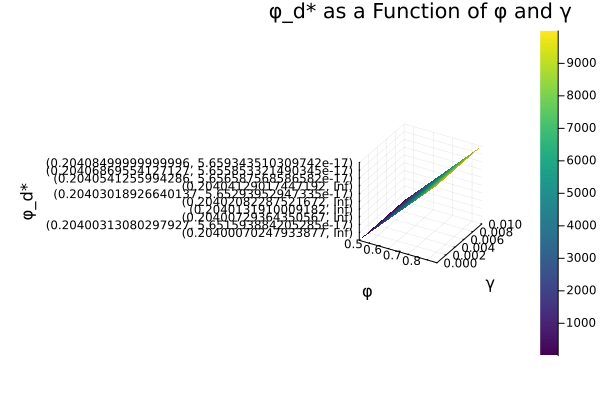

In [30]:
phi_values = range(0.45, 0.85, length=100)
gamma_values = range(0.0, 0.01, length=100)

phid_star_matrix = [find_phid_star(phi, gamma) for phi in phi_values, gamma in gamma_values]

surface(phi_values, gamma_values, phid_star_matrix, xlabel="φ", ylabel="γ", zlabel="φ_d*", title="φ_d* as a Function of φ and γ", c=:viridis)

plot!()

In [29]:
gamma_values = range(0.0, 0.01, length=100)
phi_fixed = 0.646

phid_star_values = [find_phid_star(phi_fixed, gamma) for gamma in gamma_values]

plot(gamma_values, phid_star_values, xlabel="γ", ylabel="φ_d*", title="φ_d* as a Function of γ (φ =$phi_fixed)", legend=false)

plot!()

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/fanwei/.julia/packages/PlotUtils/wo8RM/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/fanwei/.julia/packages/PlotUtils/wo8RM/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/fanwei/.julia/packages/PlotUtils/wo8RM/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/fanwei/.julia/packages/PlotUtils/wo8RM/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/fanwei/.julia/packages/PlotUtils/wo8RM/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/fanwei/.julia/packages/PlotUtils/wo8RM/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/fanwei/.julia/packages/PlotUtils/wo8RM/src/ticks.jl:194


# Minimizing the total free energy to find Phi_d

In [31]:
function F_elec(phi_d, phi, gamma)
    h = 2 * phi_c^(1/3) * a * (real((phi)^(-1/3)) - real((phi_c + phi_d - alpha * gamma^2)^(-1/3)))

    return 2 * π * a^2 * epsilon_r * epsilon_0 * psi_0^2 * exp(-h / lambda_D) / h
end

function F_tot(phi_d, phi, gamma)
    term = phi_c + phi_d - phi - alpha * gamma^2
    if term <= 0
        return Inf  # Return a large value to avoid invalid log
    end
    return F_int(phi_d) + F_ent(phi, phi_d, gamma) + F_elec(phi_d, phi, gamma)
end


F_tot (generic function with 1 method)

In [32]:
function find_min_phi_d(phi, gamma)
    boundary_condition = phi_c - phi - alpha * gamma^2

    if boundary_condition > 0
        lower_bound = 0.0
    else
        lower_bound = phi + alpha * gamma^2 - phi_c
    end

    result = optimize(phi_d -> F_tot(phi_d, phi, gamma), lower_bound, 0.35, Brent())

    return Optim.minimizer(result), Optim.minimum(result)
end

find_min_phi_d (generic function with 1 method)

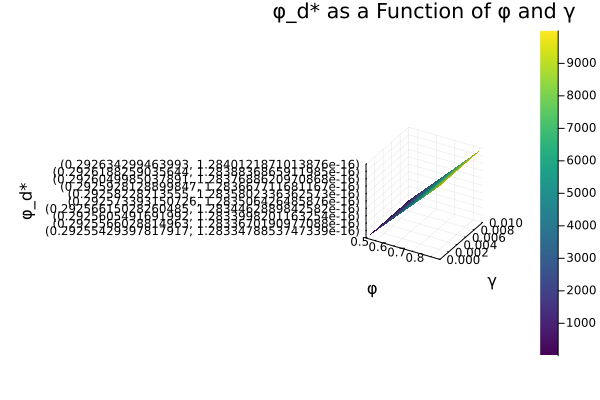

In [34]:
phi_values = range(0.45, 0.85, length=100)
gamma_values = range(0.0, 0.01, length=100)

phid_star_matrix = [find_min_phi_d(phi, gamma) for phi in phi_values, gamma in gamma_values]

surface(phi_values, gamma_values, phid_star_matrix, xlabel="φ", ylabel="γ", zlabel="φ_d*", title="φ_d* as a Function of φ and γ", c=:viridis)

plot!()

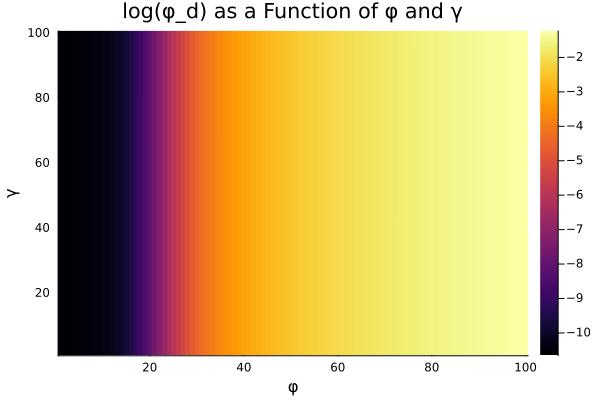

In [35]:
phi_d_values = zeros(length(phi_values), length(gamma_values))
for i in 1:length(phi_values)
    for j in 1:length(gamma_values)
        phi = phi_values[i]
        gamma = gamma_values[j]
        phi_d, _ = find_min_phi_d(phi, gamma)
        phi_d_values[i, j] = phi_d
    end
end

heatmap(log.(phi_d_values)', xlabel="φ", ylabel="γ", zlabel="log(φ_d)", title="log(φ_d) as a Function of φ and γ")


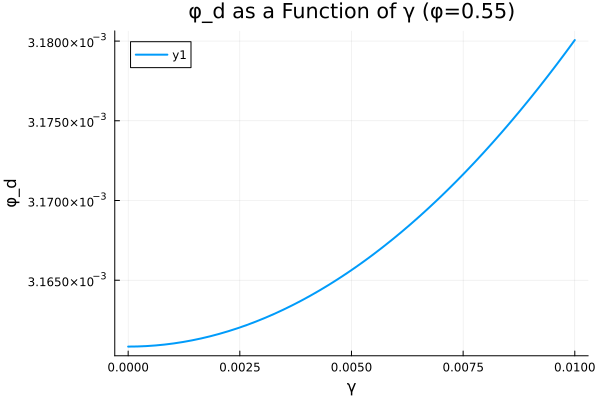

In [39]:
phi_fixed = 0.55

gamma_values = range(0, 0.01, length=50)

phi_d_values = zeros(length(gamma_values))

for i in 1:length(gamma_values)
    gamma = gamma_values[i]
    phi_d, _ = find_min_phi_d(phi_fixed, gamma)
    phi_d_values[i] = phi_d
end

plot(gamma_values, phi_d_values, xlabel="γ", ylabel="φ_d", title="φ_d as a Function of γ (φ=$phi_fixed)", lw=2)


$$
\frac{d\left( F_{\text{tot}} \right)}{d \phi_d} = 8 \pi \xi a^2 \phi_d - \frac{3 k_B T}{a^3} \left[ \frac{1}{\phi_c + \phi_d - \phi - \alpha \gamma^2} \right] + \left[ 2 \pi a^2 \epsilon_r \epsilon_0 \psi_0^2 \exp\left( - \frac{h}{\lambda_D} \right) \cdot \frac{-h/\lambda_D - 1}{h^2} \right] \notag \\
\quad \cdot \left[ \frac{2}{3} \phi_c^{1/3} a \left( \phi_c + \phi_d - \alpha \gamma^2 \right)^{-4/3} \right] =  F(\phi_d, \phi) = 0

$$




$$
\frac{dF}{d\phi} = \frac{\partial F}{\partial \phi_d} \cdot \frac{d\phi_d}{d\phi} + \frac{\partial F}{\partial \phi} = 0
$$

$$
\frac{d\phi_d}{d\phi} = -\frac{\frac{\partial F}{\partial \phi}}{\frac{\partial F}{\partial \phi_d}}
$$


In [ ]:
function h(phi, phi_d, gamma)
    return 2 * phi_c^(1/3) * a * (phi^(-1/3) - (phi_c + phi_d - alpha * gamma^2)^(-1/3))
end

#  dF_elec/dphi_d 
function dF_elec_dphi_d(phi_d, phi, gamma)
    h_val = h(phi, phi_d, gamma)
    first_term = 2 * π * a^2 * epsilon_r * epsilon_0 * psi_0^2
    second_term = (-exp(-h_val / lambda_D)) * ((-h_val / lambda_D)-1) / (h_val^2)
    dh_dphi_d = 2 * phi_c^(1/3) * a * (1/3) * (phi_c + phi_d - alpha * gamma^2)^(-4/3)
    return first_term * second_term * dh_dphi_d
end

# total derivative
function total_derivative(phi_d, phi, gamma)
    term1 = 8 * π * xi * a^2 * phi_d
    term2 = -(3 * k_B * T / a^3) * (1 / (phi_c + phi_d - phi - alpha * gamma^2))
    term3 = dF_elec_dphi_d(phi_d, phi, gamma)
    return term1 + term2 + term3
end


function derivative_phi_d_star(phi, gamma)
    function find_phi_d_star(phi, gamma)
        f(phi_d_vec) = total_derivative(phi_d_vec[1], phi, gamma)
        result = nlsolve(f, [1e-15]; inplace=false) 
        return result.zero[1]
    end

    phi_d_star = find_phi_d_star(phi, gamma)

    # ∂F / ∂phi_d
    dF_dphi_d = ForwardDiff.derivative(phi_d -> total_derivative(phi_d, phi, gamma), phi_d_star)

    # ∂F / ∂phi
    dF_dphi = ForwardDiff.derivative(phi -> total_derivative(phi_d_star, phi, gamma), phi)

    # dphi_d / dphi
    dphi_d_star_dphi = -dF_dphi / dF_dphi_d

    return dphi_d_star_dphi
end

phi_values = range(0.55, 0.85, length=100)
gamma = 0.0  # fixed gamma

dphi_d_star_values = [derivative_phi_d_star(phi, gamma) for phi in phi_values]

plot(phi_values, dphi_d_star_values, xlabel="φ", ylabel="dφ_d*/dφ", title="dφ_d*/dφ as a Function of φ (γ = 0)", legend=false)

plot!()

In [ ]:
function find_phi_d_star(phi, gamma)
    f(phi_d_vec) = total_derivative(phi_d_vec[1], phi, gamma)
    result = nlsolve(f, [1e-15]; inplace=false)  
    return result.zero[2]
end

function derivative_phi_d_star(phi, gamma)
    phi_d_star = find_phi_d_star(phi, gamma)

    dF_dphi_d = ForwardDiff.derivative(phi_d -> total_derivative(phi_d, phi, gamma), phi_d_star)
    dF_dphi = ForwardDiff.derivative(phi -> total_derivative(phi_d_star, phi, gamma), phi)
    dphi_d_star_dphi = -dF_dphi / dF_dphi_d

    return dphi_d_star_dphi
end

In [ ]:
phi_values = range(0.55, 0.85, length=100)
gamma = 0.0  # fixed gamma

phi_d_values = [find_phi_d_star(phi, gamma) for phi in phi_values]

plot(phi_values, phi_d_values, xlabel="φ", ylabel="φ_d", title="φ_d as a Function of φ (γ = 0)", legend=false)

plot!()

$$
\Pi = \left( \frac{\phi^2}{N V_{\text{drop}}} \right) \cdot \left( \frac{\partial F_{\text{tot}}}{\partial \phi} \right)
$$


$$
\frac{\partial F_{\text{tot}}}{\partial \phi} = \frac{\partial F_{\text{tot}}}{\partial \phi_d} \cdot \frac{d\phi_d^*}{d\phi}
$$

In [ ]:
function op_pi(phi, gamma)
    phi_d_star = find_phi_d_star(phi, gamma)
    dphi_d_star_dphi = derivative_phi_d_star(phi, gamma)
    phid_star = find_phid_star(phi, gamma)
    dF_tot_dphi_d = ForwardDiff.derivative(phi_d -> F_tot(phi_d, phi, gamma), phid_star)
    dF_tot_dphi = dF_tot_dphi_d * dphi_d_star_dphi

    pi_value = (phi^2 / ( V_drop)) * dF_tot_dphi
    return pi_value / (sigma / a) 
end


In [51]:
# phi_values = range(0.55, 0.85, length=100)
# gamma_fixed = 0.0  

# pi_values = [op_pi(phi, gamma_fixed) for phi in phi_values]


# plot(phi_values, pi_values, xlabel="φ", ylabel="Π (σ/a)",  yscale=:log10, legend=false, title="Pressure Π as a function of φ (γ = 0)")

# plot!()

In [52]:
# phi_values = range(0.55, 0.85, length=100)
# gamma_fixed = 0.0  

# pi_values = [pressure_pi(phi, gamma_fixed) for phi in phi_values]

# filtered_phi_values = []
# filtered_pi_values = []

# for (phi, pi) in zip(phi_values, pi_values)
#     if pi > 0 && isreal(pi) && !isnan(pi) && isfinite(pi)
#         push!(filtered_phi_values, phi)
#         push!(filtered_pi_values, real(pi))
#     end
# end


# plot(filtered_phi_values, filtered_pi_values, xlabel="φ", ylabel="Π (σ/a)", yscale=:log10, legend=false, title="Pressure Π as a function of φ (γ = 0)")

# plot!()

## least squares fit to get the derivative

In [ ]:
function least_squares_fit(phi_d_star, phi)
    gamma_values = range(0, 0.01, length=100)  

    data = [F_tot(phi_d_star, phi, gamma) for gamma in gamma_values]

    # F_tot(γ) ≈ c0 + c1*γ + c2*γ²
    model(gamma, p) = p[1] + p[2]*gamma + p[3]*gamma.^2  

    initial_params = [0.0, 0.0, 1e-2]

    fit = curve_fit(model, gamma_values, data, initial_params)
    
    return 2 * fit.param[3]
end

In [ ]:
function Gp_prime(phi, phi_d_star)
    curvature = least_squares_fit(phi_d_star, phi)
    Gp_prime_value = (phi / V_drop) * curvature
    return Gp_prime_value
end

In [ ]:
Gp_values = [Gp_prime(phi, find_phid_star(phi, 0.01)) for phi in phi_values]

plot(phi_values, Gp_values, xlabel="φ", ylabel="G'_p", title="G'_p as a Function of φ (gamma = 0)", legend=false, yscale=:log)


In [38]:
phi_vals = range(0.45, 0.85, length=100)
gamma_vals = range(0, 0.01, length=100)

G_p_values = Float64[]  # To store G_p' for each phi
G_p_int_values = Float64[]
G_p_ent_values = Float64[]
G_p_elec_values = Float64[]

for phi in phi_vals
    gamma_list = Float64[]
    F_tot_star_list = Float64[]
    F_int_star_list = Float64[]
    F_ent_star_list = Float64[]
    F_elec_star_list = Float64[]
    
    for gamma in gamma_vals
        phi_d_star, _ = find_min_phi_d(phi, gamma)
        F_tot_star = F_tot(phi_d_star, phi, gamma)
        F_int_star = F_int(phi_d_star)
        F_ent_star = F_ent(phi, phi_d_star, gamma)
        F_elec_star = F_elec(phi_d_star, phi, gamma)
        push!(gamma_list, gamma)
        push!(F_tot_star_list, F_tot_star)
        push!(F_int_star_list, F_int_star)
        push!(F_ent_star_list, F_ent_star)
        push!(F_elec_star_list, F_elec_star)
    end

    
    model(gamma, p) = p[1] .+ p[2] .* gamma .+ p[3] .* gamma.^2
    p0 = [minimum(F_tot_star_list), 0.0, 0.0]  #initial guess
    fit = curve_fit(model, gamma_list, F_tot_star_list, p0)
    fit_int = curve_fit(model, gamma_list, F_int_star_list, p0)
    fit_ent = curve_fit(model, gamma_list, F_ent_star_list, p0)
    fit_elec = curve_fit(model, gamma_list, F_elec_star_list, p0)
    a0, a1, a2 = coef(fit)
    int_a0, int_a1, int_a2 = coef(fit_int)
    ent_a0, ent_a1, ent_a2 = coef(fit_ent)
    elec_a0, elec_a1, elec_a2 = coef(fit_elec)
    second_derivative = 2 * a2
    second_derivative_int = 2 * int_a2
    second_derivative_ent = 2 * ent_a2
    second_derivative_elec = 2 * elec_a2

    G_p_prime = (phi / V_drop) * second_derivative
    G_p_prime_int = (phi / V_drop) * second_derivative_int
    G_p_prime_ent = (phi / V_drop) * second_derivative_ent
    G_p_prime_elec = (phi / V_drop) * second_derivative_elec
    push!(G_p_values, G_p_prime)
    push!(G_p_int_values, G_p_prime_int)
    push!(G_p_ent_values, G_p_prime_ent)
    push!(G_p_elec_values, G_p_prime_elec)
end

# Convert G_p_values to an array
# G_p_values = collect(G_p_values)

# Handle NaN values in G_p_values
# valid_indices = findall(!isnan, G_p_values)
# phi_vals_valid = phi_vals[valid_indices]
# G_p_values_valid = G_p_values[valid_indices]

# plot(phi_vals, (G_p_values * a / sigma), xlabel="φ", ylabel="G_p'", title="G_p' vs φ", legend=false, yscale=:log10)
# Plot G_p', G_p_int', G_p_ent', G_p_elec' vs φ on the same plot with log scale on y-axis
plot(phi_vals, (G_p_values * a / sigma), label="G_p'", xlabel="φ", ylabel="G_p'", title="G_p' vs φ", yscale=:log10, lw=2)
plot!(phi_vals, (G_p_int_values * a / sigma), label="G_p_int'", lw=2)
plot!(phi_vals, (G_p_ent_values * a / sigma), label="G_p_ent'", lw=2)
plot!(phi_vals, (G_p_elec_values * a / sigma), label="G_p_elec'", lw=2)

# Show the plot
display(plot!)
# savefig("Gp_vs_phi_plot.png")


plot! (generic function with 4 methods)

In [ ]:
plot(phi_vals, (G_p_int_values * a / sigma), xlabel="φ", ylabel="G_p'", title="G_p' vs φ", legend=false, yscale=:log10)


# the osmotic pressure

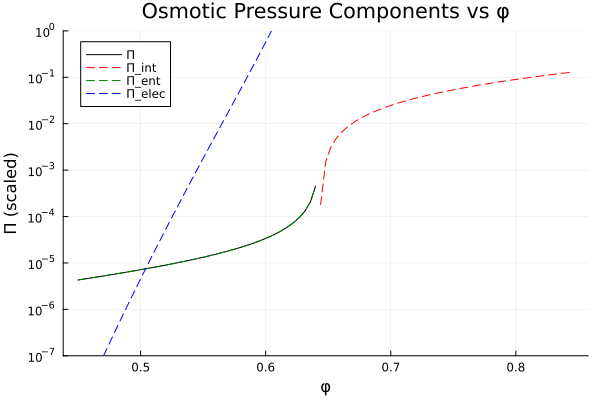

In [22]:
phi_vals = range(0.45, 0.85, length=100)  # Define range of phi values
gamma = 0  # Set gamma

F_tot_star_values = Float64[]
F_int_star_values = Float64[]
F_ent_star_values = Float64[]
F_elec_star_values = Float64[]

for phi in phi_vals
    phi_d_star, F_tot_star = find_phid_star(phi, gamma)
    push!(F_tot_star_values, F_tot_star)
    push!(F_int_star_values, F_int(phi_d_star))
    push!(F_ent_star_values, F_ent(phi, phi_d_star, gamma))
    push!(F_elec_star_values, F_elec(phi_d_star, phi, gamma))
end

# Convert to arrays for gradient calculation
F_tot_star_values = collect(F_tot_star_values)
F_int_star_values = collect(F_int_star_values)
F_ent_star_values = collect(F_ent_star_values)
F_elec_star_values = collect(F_elec_star_values)

# Calculate osmotic pressures
dF_tot_dphi = diff(F_tot_star_values) ./ diff(phi_vals)
dF_int_dphi = diff(F_int_star_values) ./ diff(phi_vals)
dF_ent_dphi = diff(F_ent_star_values) ./ diff(phi_vals)
dF_elec_dphi = diff(F_elec_star_values) ./ diff(phi_vals)

# Compute osmotic pressures
osmotic_pressure_tot = phi_vals[1:end-1].^2 / V_drop .* dF_tot_dphi
osmotic_pressure_int = phi_vals[1:end-1].^2 / V_drop .* dF_int_dphi
osmotic_pressure_ent = phi_vals[1:end-1].^2 / V_drop .* dF_ent_dphi
osmotic_pressure_elec = phi_vals[1:end-1].^2 / V_drop .* dF_elec_dphi

plot(phi_vals[1:end-1], osmotic_pressure_tot * a / sigma, label="Π", linestyle=:solid, color=:black, yscale=:log10, ylim=(1e-7, 1))
plot!(phi_vals[1:end-1], osmotic_pressure_int * a / sigma, label="Π_int", linestyle=:dash, color=:red)
plot!(phi_vals[1:end-1], osmotic_pressure_ent * a / sigma, label="Π_ent", linestyle=:dash, color=:green)
plot!(phi_vals[1:end-1], osmotic_pressure_elec * a / sigma, label="Π_elec", linestyle=:dash, color=:blue)

xlabel!("φ")
ylabel!("Π (scaled)")
title!("Osmotic Pressure Components vs φ")
